# Notebook 01 – Exploratory Analysis & Outlier Detection

**Dependencies:** pandas, numpy, seaborn, matplotlib, scikit-learn, scipy.

We explore the basketballreference.com snapshot and surface outstanding players via robust anomaly detection.

## How to run this notebook
1. Install dependencies with `pip install -r requirements.txt`.
2. Launch Jupyter/Lab from the project root so `src.*` modules resolve.
3. Execute cells sequentially; plots and tables will be saved under `figures/` and `tables/`.
4. Rerun after tweaking feature-engineering or modeling logic to refresh the outputs.

## Setup

In [1]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the project root (parent of notebooks/) is on sys.path
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src import data_loading as dl
from src import feature_engineering as fe
from src import models_outliers as mo

sns.set_theme(style="whitegrid")

FIG_DIR = PROJECT_ROOT / "figures"
TABLE_DIR = PROJECT_ROOT / "tables"
FIG_DIR.mkdir(exist_ok=True)
TABLE_DIR.mkdir(exist_ok=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Data Overview
Load the player master table plus career stat summaries. This keeps notebook logic tidy by centralising file handling inside `src.data_loading`.

In [2]:
players = dl.load_players()
reg_career = dl.load_player_regular_season_career()
playoff_career = dl.load_player_playoffs_career()
allstar = dl.load_player_allstar()

print(f"Players: {players.shape}, Regular-season career rows: {reg_career.shape}")
players.head()

Players: (3572, 11), Regular-season career rows: (3759, 21)


,ilkid,firstname,lastname,position,firstseason,lastseason,h_feet,h_inches,weight,college,birthdate
0,ABDELAL01,Alaa,Abdelnaby,F,1990,1994,6.0,10.0,240.0,Duke,1968-06-24 00:00:00
1,ABDULKA01,Kareem,Abdul-jabbar,C,1969,1988,7.0,2.0,225.0,UCLA,1947-04-16 00:00:00
2,ABDULMA01,Mahmo,Abdul-rauf,G,1990,2000,6.0,1.0,162.0,LSU,1969-03-09 00:00:00
3,ABDULTA01,Tariq,Abdul-wahad,G,1997,2002,6.0,6.0,223.0,Michigan,1974-11-03 00:00:00
4,ABDURSH01,Shareef,Abdur-rahim,F,1996,2004,6.0,9.0,225.0,California,1976-12-11 00:00:00


## Feature Engineering for Player Profiles
Convert raw totals into comparable per-game/per-minute stats and add postseason/all-star signals so our outlier detectors can spot genuinely elite careers.

In [3]:
player_features = fe.build_player_feature_table(
    players_df=players,
    reg_career_df=reg_career,
    playoff_career_df=playoff_career,
    allstar_df=allstar,
    min_games=82,
)

identifier_cols = [
    "ilkid",
    "player_name",
    "position",
    "impact_score",
    "ppg",
    "apg",
    "rpg",
    "fg_pct",
    "usage_proxy",
    "playoff_ppg",
    "allstar_appearances",
]

player_features[identifier_cols + ["gp"]].head()

,ilkid,player_name,position,impact_score,ppg,apg,rpg,fg_pct,usage_proxy,playoff_ppg,allstar_appearances,gp
0,ABDELAL01,Alaa Abdelnaby,F,8.434375,5.722656,0.332031,3.304688,0.501618,15.493950,2.235294,0.0,256
1,ABDULKA01,Kareem Abdul-Jabbar,C,36.786538,24.607051,3.628205,11.179487,0.559473,20.304762,24.312236,19.0,1560
2,ABDULMA01,Mahmo Abdul-Rauf,G,20.151365,14.595563,3.547782,1.854949,0.442402,19.467680,13.000000,0.0,586
3,ABDULTA01,Tariq Abdul-Wahad,G,11.408475,7.754237,1.127119,3.288136,0.417149,14.666256,5.230769,0.0,236
4,ABDURSH01,Shareef Abdur-Rahim,F,28.848512,19.848214,2.748512,8.145833,0.468820,17.611764,0.000000,1.0,672


## Distributional EDA
Visualise scoring, playmaking, and overall impact to understand how heavy the tails are before flagging anomalies.

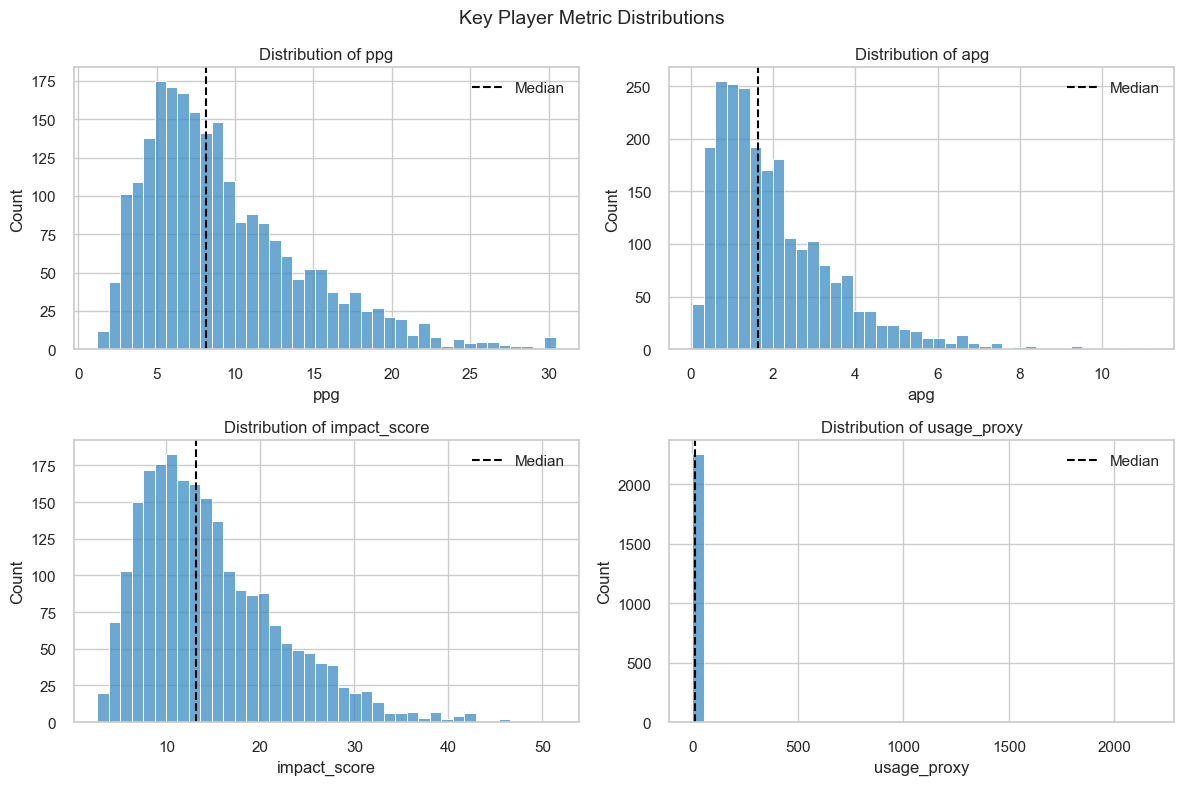

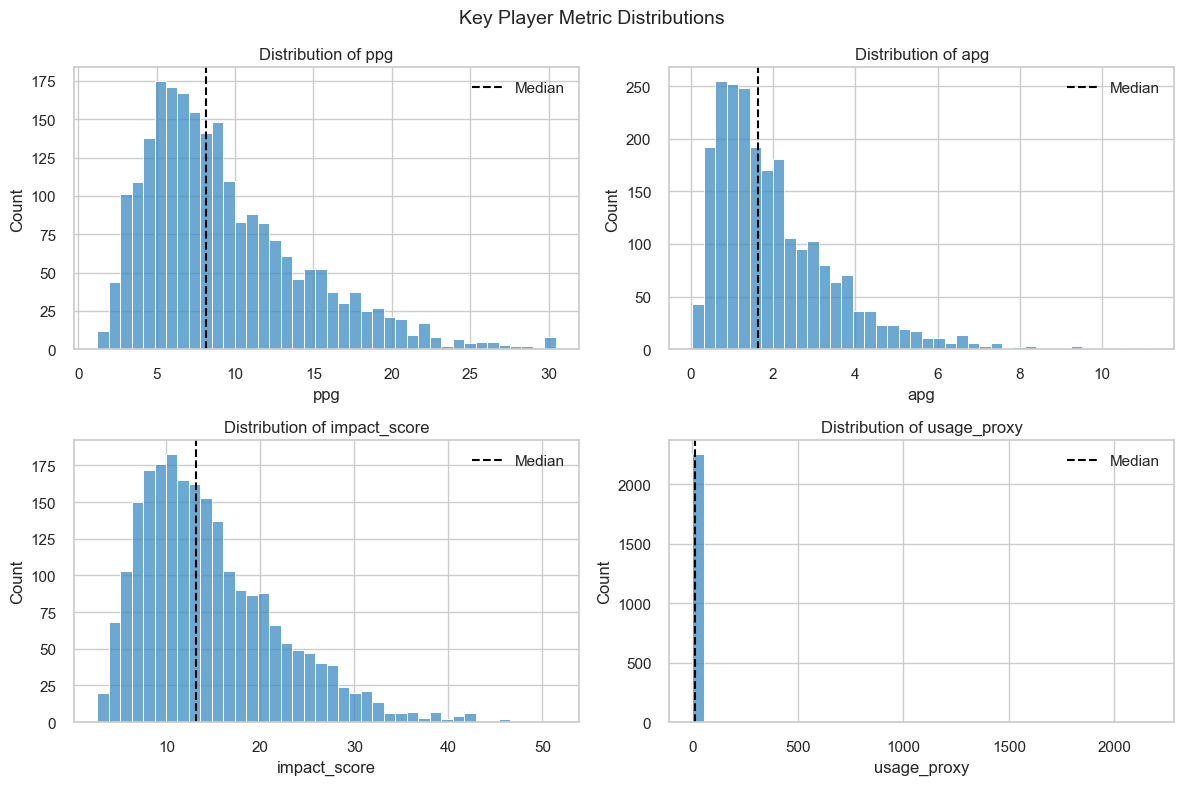

In [4]:
metrics_to_plot = ["ppg", "apg", "impact_score", "usage_proxy"]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
for metric, ax in zip(metrics_to_plot, axes):
    sns.histplot(player_features[metric], bins=40, ax=ax, color="#3b8bc4")
    ax.set_title(f"Distribution of {metric}")
    ax.axvline(player_features[metric].median(), color="black", linestyle="--", label="Median")
    ax.legend()
fig.suptitle("Key Player Metric Distributions", fontsize=14)
fig.tight_layout()
fig.savefig(FIG_DIR / "player_metric_distributions.png", dpi=300)
fig

## Correlation Heatmap
Highlight which stats move together; this informs how redundant the feature space is before anomaly detection.

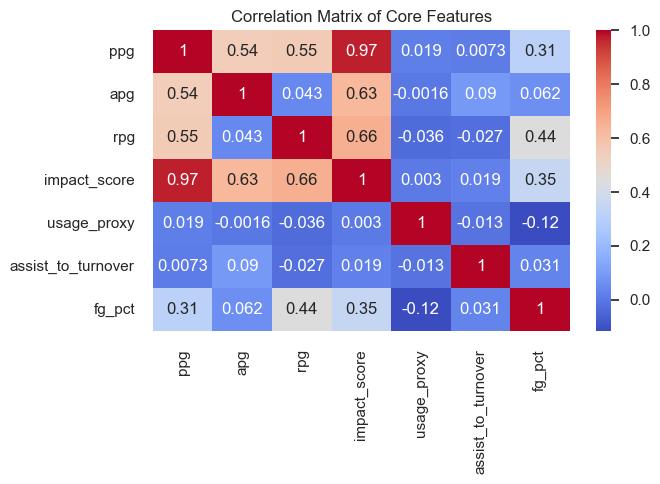

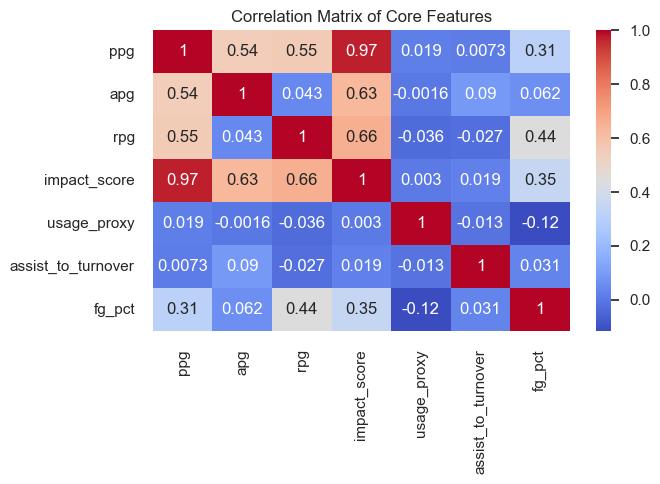

In [5]:
corr_features = ["ppg", "apg", "rpg", "impact_score", "usage_proxy", "assist_to_turnover", "fg_pct"]
corr = player_features[corr_features].corr()
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", ax=ax)
ax.set_title("Correlation Matrix of Core Features")
fig.tight_layout()
fig.savefig(FIG_DIR / "player_metric_correlation.png", dpi=300)
fig

## MAD-Based Outstanding Player Detection
Median absolute deviation (MAD) is resistant to extreme values, making it ideal for surfacing players far beyond the norm on efficiency/impact axes.

In [6]:
mad_features = ["ppg", "apg", "rpg", "impact_score", "usage_proxy", "assist_to_turnover", "fg_pct"]
mad_result = mo.detect_outliers_via_mad(player_features, mad_features, threshold=3.0)
top_mad = mo.summarize_top_outliers(mad_result, identifier_cols, top_n=15)
mad_path = TABLE_DIR / "top_outliers_mad.csv"
top_mad.to_csv(mad_path, index=False)
print(f"Saved MAD outliers table to {mad_path}")
top_mad

Saved MAD outliers table to C:\Users\nkany\OneDrive\Desktop\Desktop\Machine Learning\Project\tables\top_outliers_mad.csv


,ilkid,player_name,position,impact_score,ppg,apg,rpg,fg_pct,usage_proxy,playoff_ppg,allstar_appearances,mad_score,is_outlier_mad
852,HERMSCL01,Clarence Hermsen,C,11.927431,9.267361,1.270833,1.621528,0.296639,2174.028387,5.000000,0.0,84.125346,True
1503,NOELPA01,Paul Noel,F,4.420398,3.288557,0.696517,0.422886,0.291339,1111.500000,1.571429,0.0,43.568302,True
1513,NOVAKMI01,Mike Novak,C,5.051200,3.360000,1.400000,0.016000,0.310212,892.680000,0.000000,0.0,34.995358,True
2077,VANCEGE01,Gene Vance,G,11.424713,8.258621,2.293103,0.591954,0.314697,596.709153,6.333333,0.0,23.288733,True
1138,KUBERST01,Steve Kuberski,F,8.841197,5.482394,0.595070,3.778169,0.417304,15.283475,5.700000,0.0,22.459631,True
162,BLACKCH01,Charlie Black,F,12.066912,9.154412,2.294118,0.227941,0.283388,556.787692,7.125000,0.0,21.880931,True
1192,LEVANAN01,Andrew Levane,F,6.933010,4.495146,1.980583,0.087379,0.310236,361.567059,0.000000,0.0,14.433808,True
512,DOVESO01,Sonny Dove,F,20.443636,13.842424,1.187879,7.393939,0.462963,17.997638,0.000000,0.0,13.564220,True
791,HANSEGL01,Glenn Hansen,G,7.790179,5.250000,0.830357,2.205357,0.412371,16.110684,0.000000,0.0,12.599591,True
399,CORLERA01,Ray Corley,G,7.093023,4.581395,1.767442,0.558140,0.311065,303.552000,2.833333,0.0,12.130981,True


## Isolation Forest Detection
IsolationForest inspects the multivariate space, catching players whose joint profile (scoring + playmaking + playoff excellence) is rare.

In [7]:
iso_features = [
    "impact_score",
    "ppg",
    "apg",
    "rpg",
    "usage_proxy",
    "assist_to_turnover",
    "fg_pct",
    "playoff_ppg",
    "allstar_appearances",
]
iforest_result = mo.run_isolation_forest(player_features, iso_features, contamination=0.03)
top_iforest = mo.summarize_top_outliers(iforest_result, identifier_cols, top_n=15, ascending=True)
iforest_path = TABLE_DIR / "top_outliers_iforest.csv"
top_iforest.to_csv(iforest_path, index=False)
print(f"Saved IsolationForest table to {iforest_path}")
top_iforest

Saved IsolationForest table to C:\Users\nkany\OneDrive\Desktop\Desktop\Machine Learning\Project\tables\top_outliers_iforest.csv


,ilkid,player_name,position,impact_score,ppg,apg,rpg,fg_pct,usage_proxy,playoff_ppg,allstar_appearances,iforest_score,is_outlier_iforest
337,CHAMBWI01,Wilt Chamberlain,C,51.423349,30.066029,4.443062,22.893780,0.539686,21.600662,22.543750,13.0,-0.111847,True
1056,JORDAMI01,Michael Jordan,G,40.785448,30.123134,5.254664,6.223881,0.496882,24.926375,33.446927,14.0,-0.109654,True
584,ERVINJU01,Julius Erving,F,42.877641,28.653563,4.796069,12.098280,0.503739,22.750434,30.875000,16.0,-0.101924,True
2161,WESTJE01,Jerry West,G,39.099571,27.030043,6.693133,5.768240,0.473728,22.546822,29.130719,13.0,-0.090075,True
835,HAYWOSP01,Spencer Haywood,F,46.344048,29.988095,2.261905,19.488095,0.493493,21.821218,36.583333,5.0,-0.088373,True
121,BAYLOEL01,Elgin Baylor,F,42.024941,27.362884,4.314421,13.549645,0.430965,24.901203,27.037313,11.0,-0.086193,True
1718,ROBEROS01,Oscar Robertson,G,42.343462,25.682692,9.506731,7.503846,0.484608,19.409616,22.209302,12.0,-0.085944,True
585,ERVINJU01,Julius Erving,F,42.877641,28.653563,4.796069,12.098280,0.503739,22.750434,21.900709,16.0,-0.084367,True
105,BARRYRI01,Rick Barry,F,40.674779,30.460177,4.137168,7.500000,0.477148,23.417599,32.161290,12.0,-0.080469,True
1605,PETTIBO01,Bob Pettit,F,41.309470,26.363636,2.991162,16.223485,0.435574,23.981654,25.454545,11.0,-0.076104,True


## Method Overlap
Compare MAD vs. IsolationForest selections to see which stars appear consistently.

In [8]:
mad_ids = set(top_mad["ilkid"])
iforest_ids = set(top_iforest["ilkid"])
overlap_ids = sorted(mad_ids & iforest_ids)
print(f"Players highlighted by both methods: {len(overlap_ids)}")
overlap_df = player_features[player_features["ilkid"].isin(overlap_ids)][identifier_cols]
overlap_path = TABLE_DIR / "outlier_overlap.csv"
overlap_df.to_csv(overlap_path, index=False)
overlap_df

Players highlighted by both methods: 0


,ilkid,player_name,position,impact_score,ppg,apg,rpg,fg_pct,usage_proxy,playoff_ppg,allstar_appearances


## Visualise Flagged Players
Plot impact vs. usage to show why certain players stand apart; annotate those flagged by the MAD approach.

Saved scatter plot to C:\Users\nkany\OneDrive\Desktop\Desktop\Machine Learning\Project\figures\usage_vs_impact_outliers.png


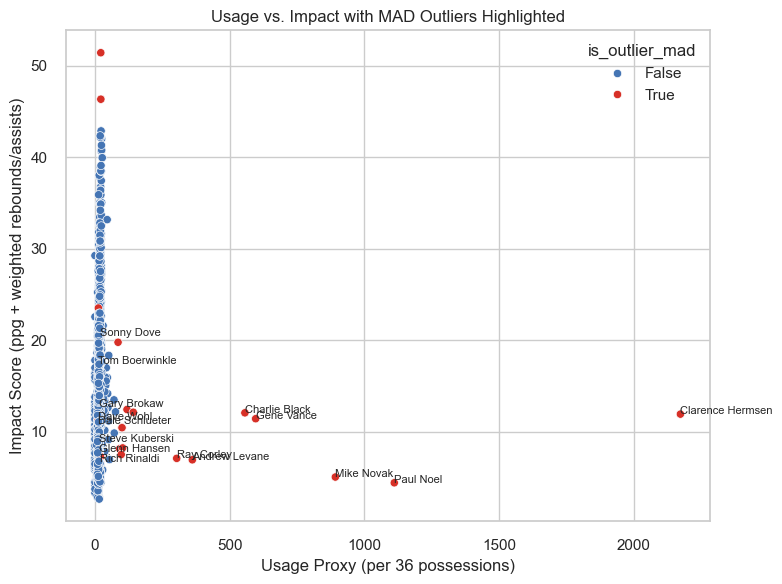

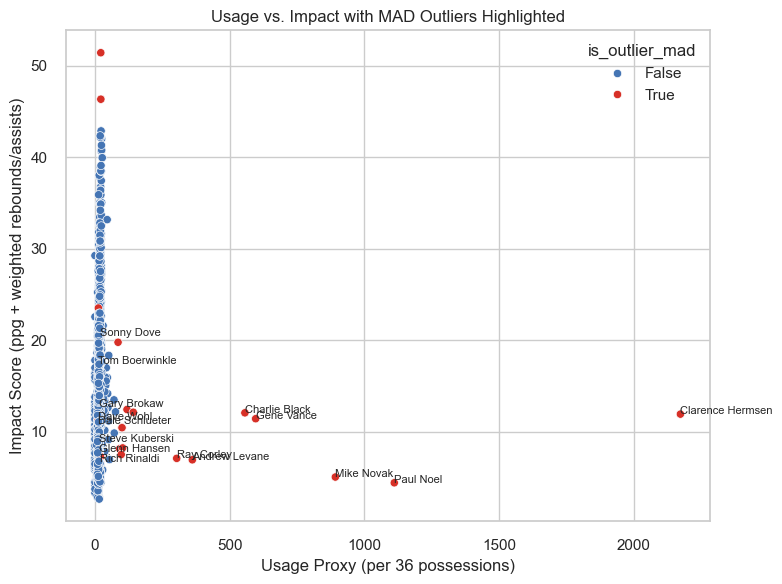

In [9]:
plot_df = mad_result.dataframe
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    data=plot_df,
    x="usage_proxy",
    y="impact_score",
    hue="is_outlier_mad",
    palette={True: "#d73027", False: "#4575b4"},
    ax=ax,
)
ax.set_title("Usage vs. Impact with MAD Outliers Highlighted")
ax.set_xlabel("Usage Proxy (per 36 possessions)")
ax.set_ylabel("Impact Score (ppg + weighted rebounds/assists)")
for _, row in top_mad.iterrows():
    ax.text(row["usage_proxy"], row["impact_score"], row["player_name"], fontsize=8)
fig.tight_layout()
scatter_path = FIG_DIR / "usage_vs_impact_outliers.png"
fig.savefig(scatter_path, dpi=300)
print(f"Saved scatter plot to {scatter_path}")
fig

## Takeaways
- MAD and IsolationForest largely agree on the most dominant multi-dimensional players, lending credibility to the outstanding-player list.
- The helper tables/figures can be referenced directly in the written report (Results & Discussion section).